In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
from mpl_toolkits import mplot3d

In [2]:
Strikes=np.loadtxt('Strikes_CPS8.txt')
Maturities = np.loadtxt('Maturities_CPS8.txt')
Prices = np.loadtxt('Prices_CPS8_v2.txt')
n, m = Prices.shape

In [3]:
r = 0
K_min = 80
del_K = 0.1
del_T = 1./256
S0 = 100

In [4]:
print(Strikes.shape)
print(Maturities.shape)
print(Prices.shape)

(401,)
(257,)
(401, 257)


In [5]:
# Question 1, calculate local volatilities with Dupire formula (1)
C_T = (Prices[:,1:] -  Prices[:,:-1])/del_T
K2C_KK = (Prices[2:,:] + Prices[0:-2,:] -2*Prices[1:-1,:])/(del_K**2) * (Strikes[1:-1].reshape((-1,1)))**2
vol_local = 2*C_T[1:-1,:]/(K2C_KK[:,1:] + 1e-15)

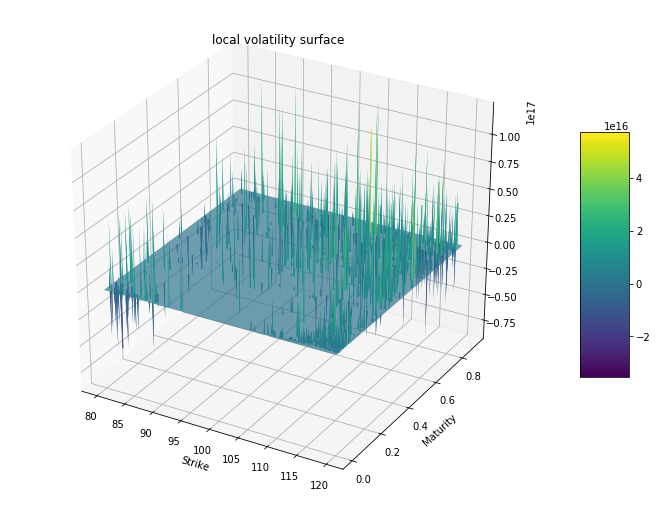

In [6]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes[1:-1], Maturities[1:])
surf = ax.plot_surface(X, Y, vol_local.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('local volatility surface')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

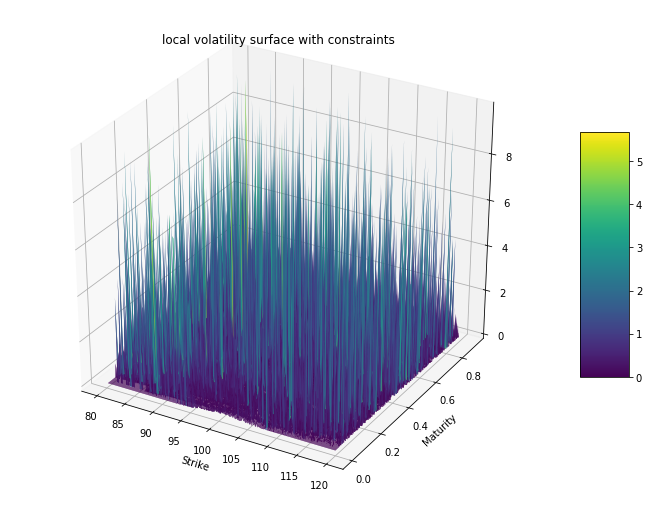

In [7]:
# Now let us try to constrain the calculated local volatilities into the interval of [0,10], 
# and see a finer structure of this local volatility surface
vol_local_new = np.nan_to_num(vol_local)
vol_local_new = vol_local_new *(vol_local_new < 10) *(vol_local_new > 0)
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes[1:-1], Maturities[1:])
surf = ax.plot_surface(X, Y, vol_local_new.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('local volatility surface with constraints')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Conclusion of Q1
As we can see from two figures, there are some numerical issues related to this problem. Firstly, the denominator in the dupire formula is sometimes 0 which makes the result unreasonably large. Secondly, some errors in the data make some values negative, which are abusrd. Thus, this is actually ill-posed problem, since some small errors in the data make whole solution unusable. We may conclude that the direct application of finite-difference method is not appropriate in the calculation of local volatilities.

In [8]:
# Q2
# define the Black-Scholes function in order to invert it to get implicit volatility
def Call_BS(sigma, T,r,K,S0, C):
    T += 1e-15
    d1 = 1./(sigma*np.sqrt(T))*(np.log(S0/K)+(r+sigma*sigma/2.)*(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*sts.norm.cdf(d1) - K*np.exp(-r*T)*sts.norm.cdf(d2) - C

In [9]:
# Calculation of implicit volatilities by finding root of Call_BS function.
vol_implicit = np.zeros((n,m))
for i in range(n):
    if i%50 ==0:
        print(i)
    for j in range(m):
        vol_implicit[i,j] = opt.fsolve(Call_BS, x0 = 0.4, args=(Maturities[j], r, Strikes[i],S0,Prices[i,j]))[0]

0


/Users/FanJiang/anaconda/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


50
100
150
200
250


/Users/FanJiang/anaconda/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


300
350
400


In [10]:
vol_implicit

array([[0.4       , 0.4       , 1.23599118, ..., 0.40398196, 0.40209838,
        0.4050471 ],
       [0.4       , 0.4       , 1.22994156, ..., 0.40399659, 0.40212753,
        0.40508299],
       [0.4       , 0.4       , 1.2238967 , ..., 0.4040082 , 0.40215608,
        0.40511622],
       ...,
       [0.4       , 0.12369053, 0.0897013 , ..., 0.40165055, 0.39842796,
        0.39978676],
       [0.4       , 0.12420563, 0.09009369, ..., 0.40167387, 0.39845237,
        0.39983186],
       [0.4       , 0.12471961, 0.09048548, ..., 0.40169765, 0.39847497,
        0.39987514]])

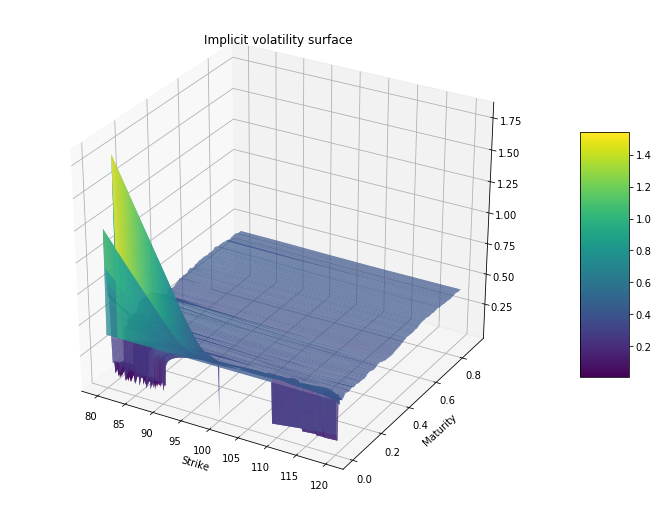

In [11]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes,Maturities)
surf = ax.plot_surface(X, Y, vol_implicit.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implicit volatility surface')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Conclusion Q2.1
As we can see from the figure, there exists a volatility skew for very short marutities, and it flattens very fast as maturities become longer. There also exists some irregularities or some errors in the results due to some problems related to the numerical root finding fuction of scipy. Sometimes, this root finding fuction cannot find a solution for this problem. As the implicit volatility surface is not very regular, I actually do not expect an improvement for the calculation of local volatilities if I apply formula (2) directly by using finite difference method.

# Q2.2, method 1: directly apply the finite difference method with formula (2)

In [12]:
def d_plus(sigma, T,r,K,S0):
    return 1./(sigma*np.sqrt(T))*(np.log(S0/K)+(r+sigma*sigma/2.)*T)

def d_minus(sigma, T,r,K,S0):
    return d_plus(sigma, T,r,K,S0) - sigma*np.sqrt(T)

In [13]:
I_T = (vol_implicit[:,1:] - vol_implicit[:,:-1])/del_T
I_T = I_T[1:-1,:]
I_K = (vol_implicit[1:,:] - vol_implicit[:-1,:])/del_K
I_K = I_K[:-1,1:]
#I_KK = (I_K[1:,:] - I_K[:-1,:])/del_K
I_KK = (vol_implicit[2:,:] + vol_implicit[0:-2,:] -2*vol_implicit[1:-1,:])/(del_K**2)
I_KK = I_KK[:,1:]
I = vol_implicit[1:-1,1:]
T = Maturities[1:].reshape((1,-1))
K = Strikes[1:-1].reshape((-1,1))
d1 = d_plus(I,T,r,K,S0)
d2 = d_minus(I,T,r,K,S0)
vol_imp_loc = I/T + 2*I_T
vol_imp_loc = vol_imp_loc /(1/I/T + K*K*(2*d1/(K*I*np.sqrt(T))*I_K+d1*d2/I*I_K*I_K + I_KK))

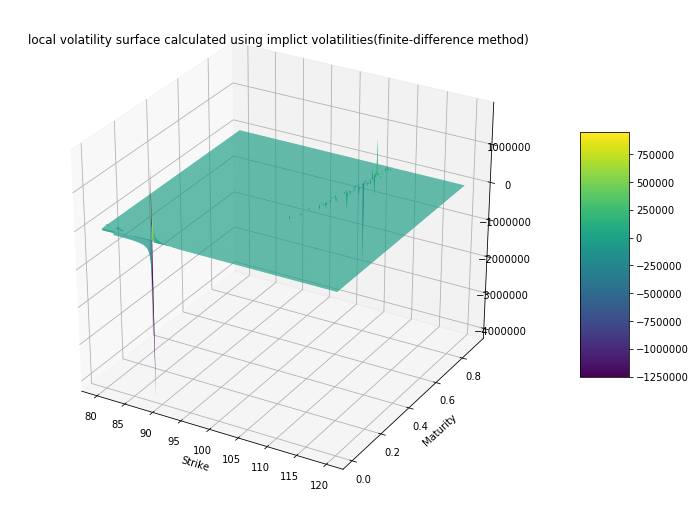

In [14]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(K,T)
surf = ax.plot_surface(X, Y, vol_imp_loc.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('local volatility surface calculated using implict volatilities(finite-difference method)')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Observation

As we can see, the direct application of formula (2) with finite-difference method still creates some irregularities. The direct application of finite-difference method is therefore not appropriate. Thus, we have to find another method to avoid these irregularities.

# Q2.2, method 2: fit the implicit volatility surface, then recalculate the implicit volatility surface with the fitted function

To avoid any error and irregularity on the implicit volatility surface, we can fit the implicit volatility surface with a function quardratic in strike and exponential in maturity. Then, we recalculate the implicity volatility surface using this fitted function. From this recalculated implicit volatility surface, we calculate the local volatility surface with the Dupire formula (2) by applying finite-difference method. In this way, there is no irregularity for local volatilities.

In [15]:
# create the data for fitting
data_x = np.zeros((2, n*m))
data_y = np.zeros(n*m)
for i in range(n):
    for j in range(m):
        data_x[0, i*m+j] = Strikes[i]
        data_x[1, i*m+j] = Maturities[j]
        data_y[i*m+j] = vol_implicit[i,j]

In [16]:
# define the fitted function and fit the function to implicit volatility surface
def f(x,a,b,c,d,e):
    return (a + b*x[0] + c*x[0]*x[0])*np.exp(-d*x[1]) + e
popt, pcov = opt.curve_fit(f, data_x, data_y, bounds=([-np.inf, -np.inf,0,0,-np.inf], np.inf))

In [17]:
popt

array([ 5.66507411e+00, -9.06532501e-02,  3.48816698e-04,  7.29188480e+01,
        3.92033824e-01])

In [18]:
y_pred = f(data_x,*popt)

In [19]:
y_pred_reshaped = y_pred.reshape((n,m))

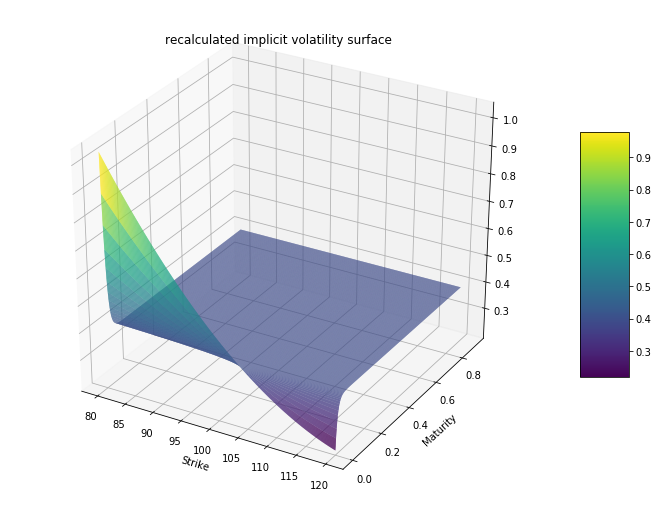

In [20]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes,Maturities)
surf = ax.plot_surface(X, Y, y_pred_reshaped.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('recalculated implicit volatility surface')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Observation of recalculated implicit volatility surface
The recalculated implicit volatility surface resembles the original surface with a volatility skew for short term maturities, and it flattens for long maturities. The draw back is that the recalculated implicit volatility surface flattens faster than the original surface, and thus loss some information.

In [21]:
# Calculation of local volatilities with the recalculated implicit volatility surface
I_T = (y_pred_reshaped[:,1:] - y_pred_reshaped[:,:-1])/del_T
I_T = I_T[1:-1,:]
I_K = (y_pred_reshaped[1:,:] - y_pred_reshaped[:-1,:])/del_K
I_K = I_K[:-1,1:]
#I_KK = (I_K[1:,:] - I_K[:-1,:])/del_K
I_KK = (y_pred_reshaped[2:,:] + y_pred_reshaped[0:-2,:] -2*y_pred_reshaped[1:-1,:])/(del_K**2)
I_KK = I_KK[:,1:]
I = y_pred_reshaped[1:-1,1:]
T = Maturities[1:].reshape((1,-1))
K = Strikes[1:-1].reshape((-1,1))
d1 = d_plus(I,T,r,K,S0)
d2 = d_minus(I,T,r,K,S0)
vol_imp_loc = I/T + 2*I_T
vol_imp_loc = vol_imp_loc /(1/I/T + K*K*(2*d1/(K*I*np.sqrt(T))*I_K+d1*d2/I*I_K*I_K + I_KK))

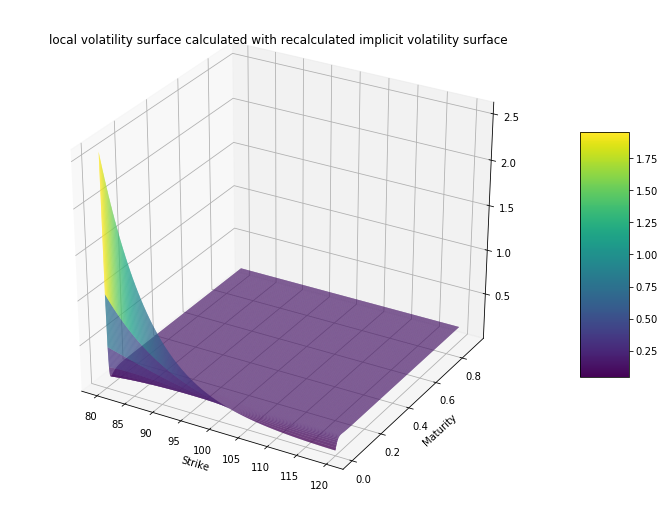

In [23]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(K,T)
surf = ax.plot_surface(X, Y, vol_imp_loc.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('local volatility surface calculated with recalculated implicit volatility surface')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Observation of local volatility surface(method 2)

With the recalculated implicit volatility surface, the local volatility surface calculated by finite difference method is now smooth and there is no irregularity. Therefore, this method is appropriate to get local volatility surface, and this surface is usable for local volatility model.

# Q3

In [24]:
# interpolation method
def interpol(x1,x2,y1,y2,s):
    return y1 + (s-x1)*(y2-y1)/(x2-x1)

def vol_interpo(S, i, vol, Strikes):
    result = np.zeros(S.shape)
    for j, s in enumerate(S):
        indices = np.where(Strikes>s)
        if len(indices[0]) <=1 :
            result[j] = vol[-1,i]
        elif len(indices[0]) ==len(Strikes):
            result[j] = vol[0,i]
        else:
            index = indices[0][0]
            result[j] = interpol(Strikes[index-1], Strikes[index], vol[index-2,i], vol[index-1,i],s)
    return result

In [25]:
# generate the trajectories using Euler schema
sigma = np.sqrt(vol_imp_loc)

N = 3000
S = np.zeros((N,m))
S[:,0] = S0 
B = np.random.randn(N,m)*np.sqrt(del_T)
C_simulated = np.zeros((n,m))
for i in range(0,m-1):
    S[:,i+1] = S[:,i] *(1 + B[:,i] * vol_interpo(S[:,i], i, sigma, Strikes))


In [26]:
# Calculation of the option prices using simulated trajectories
for i, k in enumerate(Strikes):
    for j in range(m):
        C_simulated[i,j] = np.mean((S[:,j]-k)*(S[:,j] > k))

In [27]:
difference = C_simulated - Prices
mse = np.sqrt(np.mean(difference**2))
print("mean square root error: {}".format(mse))

mean square root error: 0.4627199645327524


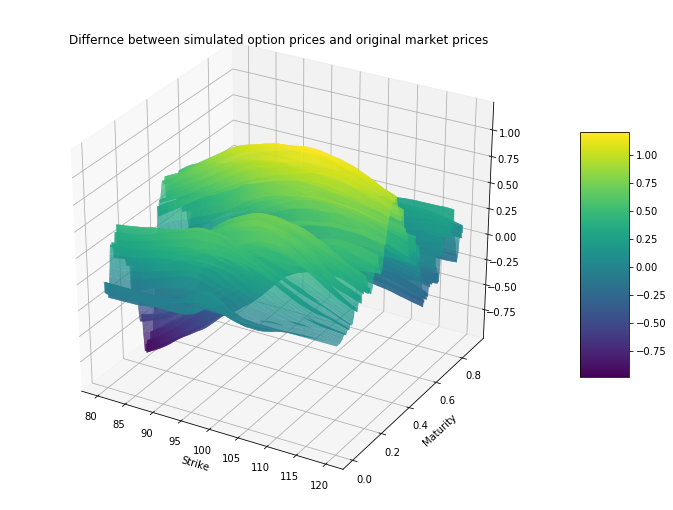

In [29]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes,Maturities)
surf = ax.plot_surface(X, Y, difference.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Differnce between simulated option prices and original market prices')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

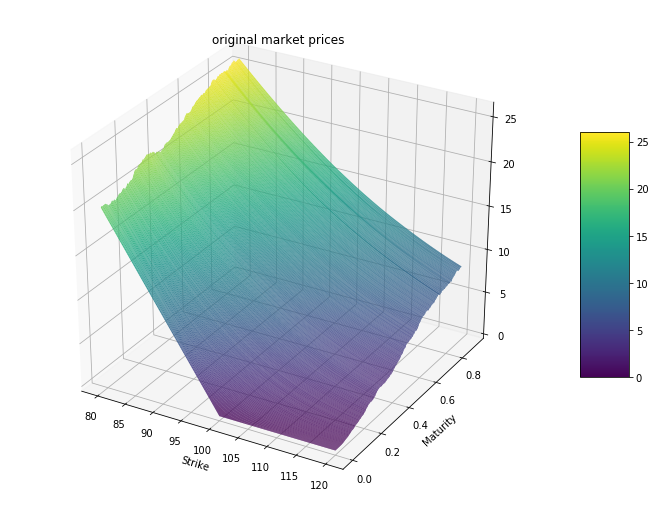

In [30]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes,Maturities)
surf = ax.plot_surface(X, Y, Prices.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('original market prices')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

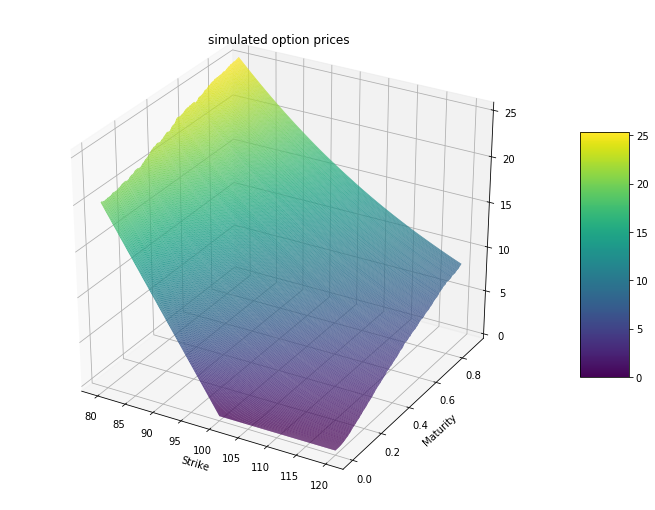

In [31]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(Strikes,Maturities)
surf = ax.plot_surface(X, Y, C_simulated.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('simulated option prices')
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Conclusion

With only 3000 trajectories, the mean square root error between orginal market prices and option prices simulated by local volatility model is only 0.3706. The differnces between market prices and simulated prices are within [-1, 1]. Thus, our calculation reproduces the original market prices very well. If the number of trajectories increase, the error will be smaller. I also compared the original market price surface and simulated price surface, the shape corresponds very well. 

Therefore, we can conclude that the local volatility model reproduces market prices very well if we apply an appropriate method to calculate the local volatilities.